In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy

from sklearn.neighbors import KNeighborsClassifier


from tqdm import tqdm

In [78]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
value_to_predict = 'population'


********************
HEART
xgboost
chrXY
********************


5it [00:08,  1.62s/it]


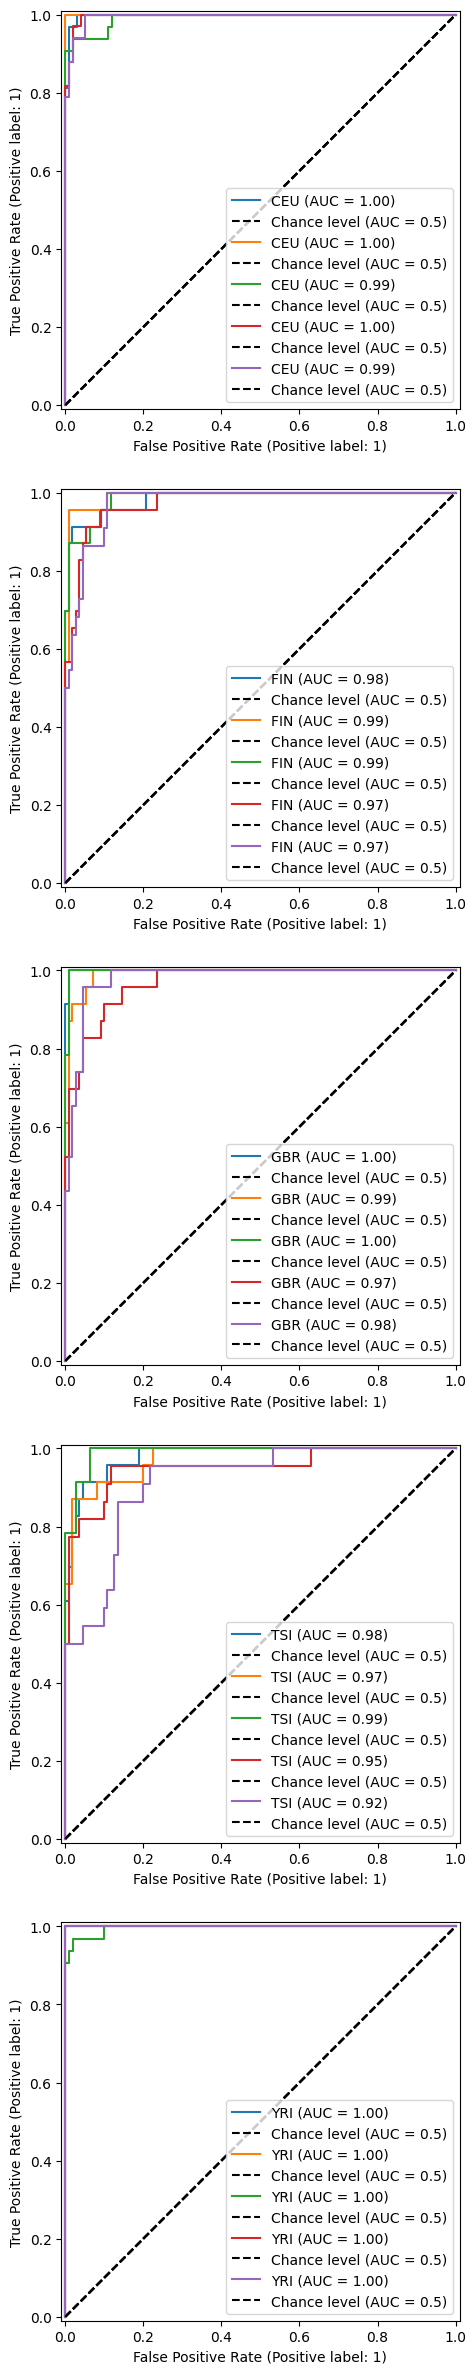

In [111]:
result_dict = {}
cm_total = np.zeros((5,5))

for organ in ['HEART']:
    result_dict[organ] = {}
    # for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    for sex in ['chrXY']:
        result_dict[organ][sex] = {}

        print("*" * 20)
        print(organ)
        print(model_type)
        print(sex)
        print("*" * 20)
        
        with open(ml_models_fdir/f'{model_type}.json', 'r') as file:
            model_params = json.load(file)
        model_params = model_params[value_to_predict]

        data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

        features = pd.read_hdf(
            fdir_processed / f'feature_importance.{model_type}.{"Sex"}.organ_{organ}.h5',
            key=f'{sex}',
        )
        features = features[feature_importance_method]
        # features = features.sort_values(ascending=False)
        
        if organ != "None":
            fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
            fname = fname.name

            data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
            features = features.loc[features.index.intersection(data_eval.columns)]
            features = features.sort_values(ascending=False)
            
        features_list = features
        
        data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
        
        # data = data[features_list.index]
        data = data[features_selected]
        
        # features = data.columns
    

        X = data.values
        y = data_header[value_to_predict]

        label_encoder = LabelEncoder().fit(y)
        y = label_encoder.transform(y)

        # label_encoder = OneHotEncoder().fit(pd.DataFrame(y))
        # y = y.astype('category')        

        cv = StratifiedKFold(n_splits=5)

        # fig, ax = plt.subplots(figsize=(6, 6))
        fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]

            # train_scaler = StandardScaler().fit(X_train)
            # test_scaler = StandardScaler().fit(X_test)

            train_scaler = RobustScaler().fit(X_train)
            test_scaler = RobustScaler().fit(X_test)

            X_train = train_scaler.transform(X_train)
            X_test = test_scaler.transform(X_test)
            
            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test

            # y_val = label_encoder.transform(pd.DataFrame(y_val)).toarray()
            # y_train_= label_encoder.transform(pd.DataFrame(y_train_)).toarray()

            model_params['enable_categorical'] = True

            model = xgb.XGBClassifier(**model_params)
            model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)

            pred = model.predict(cupy.array(X_test))
            pred_prob = model.predict_proba(cupy.array(X_test))
            
            cm = confusion_matrix(y_test, y_pred=pred)
            cm_total=cm_total+cm
            
            for j in range(pred_prob.shape[1]):
                RocCurveDisplay.from_predictions(
                    LabelBinarizer().fit_transform(y_test)[:,j], pred_prob[:,j],
                    plot_chance_level=True, name=label_encoder.classes_[j],
                    ax=axs[j])

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 0, 2, 3, 1, 2, 0, 4, 3,
       2, 3, 4, 1, 0, 0, 4, 2, 3, 3, 1, 4, 0, 1, 1, 2, 3, 4, 3, 3, 1, 0,
       4, 2, 4, 3, 4, 1, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 3, 4, 0, 4, 4, 1,
       0, 3, 1, 0, 4, 1, 1, 3, 1, 1, 3, 0, 0, 0, 2, 0, 1, 0, 4, 3, 4, 4,
       0, 4, 3, 1, 2, 1, 2, 4, 4, 4, 0, 0, 1, 4, 4, 4, 2, 2, 1, 1, 4, 4,
       1, 0, 2, 4, 3, 0, 4, 0, 3, 3, 0, 1, 0, 0, 1, 3, 4, 0, 4, 4, 4, 0,
       0])

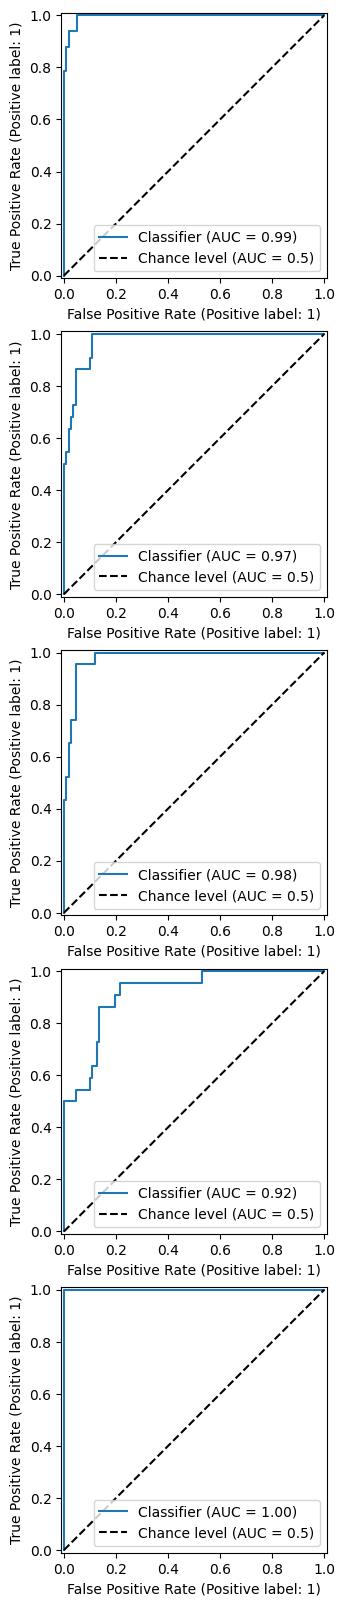

In [104]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for i in range(pred_prob.shape[1]):
    RocCurveDisplay.from_predictions(
        LabelBinarizer().fit_transform(y_test)[:,i], pred_prob[:,i],
        plot_chance_level=True,
        ax=axs[i]
)
# features

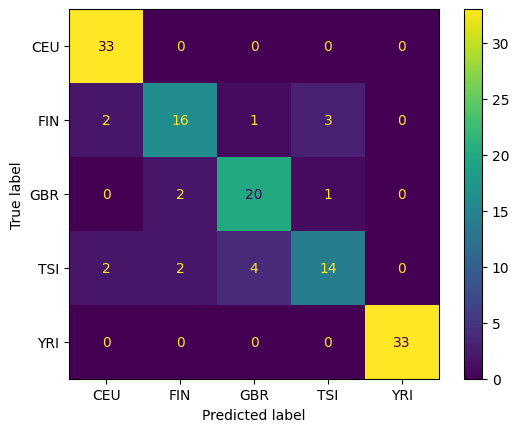

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, y_pred=pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()


In [82]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_values.mean(axis=2).shape

(133, 8668)

In [83]:
model.classes_, features_list.index

(array([0, 1, 2, 3, 4]),
 Index(['ENST00000602495.1', 'ENST00000647913.2', 'MSTRG.36020.14',
        'MSTRG.35413.93', 'ENST00000300184.8', 'MSTRG.1913.3',
        'ENST00000675525.1', 'MSTRG.25537.5', 'ENST00000674495.1',
        'ENST00000307259.9',
        ...
        'MSTRG.30823.4', 'MSTRG.30837.10', 'ENST00000396709.5',
        'MSTRG.30934.21', 'MSTRG.30934.16', 'ENST00000521747.5',
        'ENST00000297029.10', 'MSTRG.30894.2', 'MSTRG.30879.11',
        'MSTRG.14865.16'],
       dtype='object', length=8668))

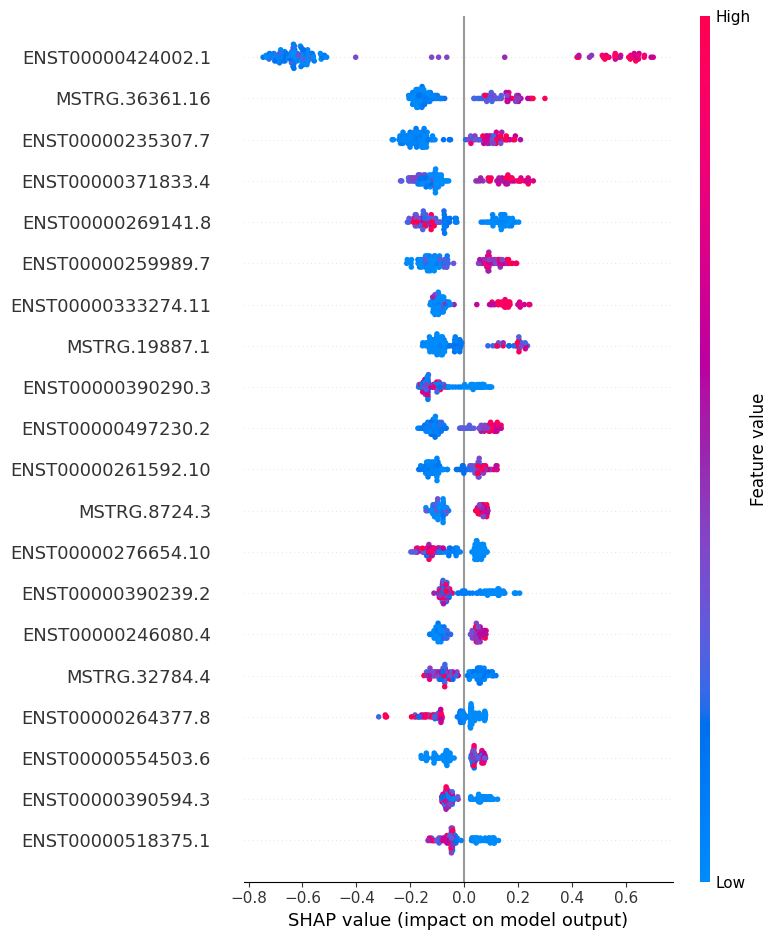

In [84]:
shap.summary_plot(
    shap_values.mean(axis=2), 
    X_test, 
    # plot_type="bar", 
    class_names=label_encoder.classes_, 
    feature_names= features_list.index
    )

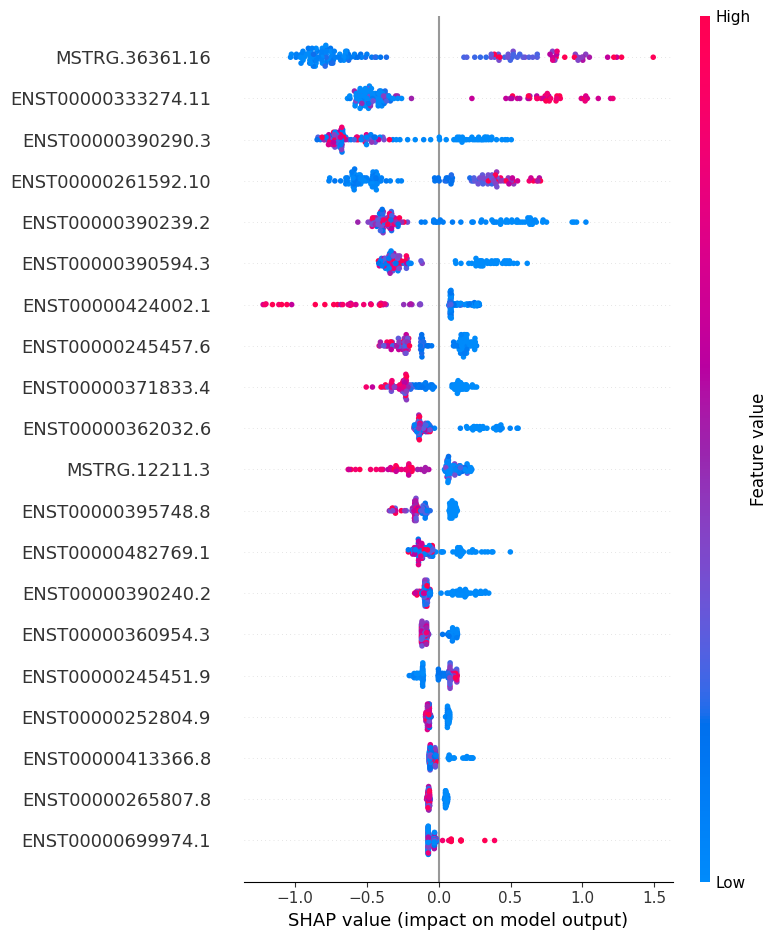

In [85]:
shap.summary_plot(
    shap_values[..., 0], 
    X_test, 
    # plot_type="bar", 
    class_names=label_encoder.classes_, 
    feature_names= features_list.index
    )

In [86]:
selected_features_list = []
for i in range(5):
    selected_features = features_list.index[np.argsort(np.abs(shap_values[..., i]).mean(axis=0))[-10:]].tolist()
    selected_features_list.extend(selected_features)
    
features_selected = list(set(selected_features_list))
len(features_selected)

46

In [92]:
features_selected

['ENST00000246080.4',
 'MSTRG.36361.16',
 'ENST00000390239.2',
 'ENST00000511507.5',
 'MSTRG.21382.39',
 'MSTRG.32784.4',
 'MSTRG.8724.3',
 'ENST00000259989.7',
 'ENST00000521389.6',
 'ENST00000583088.6',
 'ENST00000603054.1',
 'ENST00000371833.4',
 'ENST00000264377.8',
 'ENST00000677747.1',
 'MSTRG.28475.4',
 'ENST00000390290.3',
 'ENST00000483662.2',
 'ENST00000276654.10',
 'ENST00000245457.6',
 'MSTRG.15427.23',
 'ENST00000424002.1',
 'ENST00000443669.5',
 'MSTRG.14422.1',
 'MSTRG.23343.23',
 'MSTRG.32213.20',
 'ENST00000362032.6',
 'ENST00000472406.1',
 'ENST00000554503.6',
 'ENST00000333274.11',
 'ENST00000393158.7',
 'ENST00000235307.7',
 'ENST00000497230.2',
 'ENST00000453000.1',
 'ENST00000390594.3',
 'ENST00000606115.1',
 'ENST00000390240.2',
 'ENST00000480899.5',
 'MSTRG.9869.5',
 'MSTRG.29230.53',
 'ENST00000269141.8',
 'ENST00000261592.10',
 'MSTRG.1733.1',
 'ENST00000699569.1',
 'ENST00000474889.6',
 'ENST00000518375.1',
 'MSTRG.19887.1']

In [87]:
data_header.head().T

,ERR188021,ERR188022,ERR188023,ERR188024,ERR188025
Assay Type,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq
AvgSpotLen,150,150,152,150,152
Bases,4876174200,3348579900,5548298680,3572181450,5348693800
BioProject,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366
BioSample,SAMEA1573446,SAMEA1573207,SAMEA1573500,SAMEA1573203,SAMEA1573346
Broker_name,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress
Bytes,3559612733,2387687573,3922060114,2494830964,3609467912
Center Name,UNIGE,UNIGE,CRG,UNIGE,CRG
common_name,human,human,human,human,human
Consent,public,public,public,public,public


<Axes: >

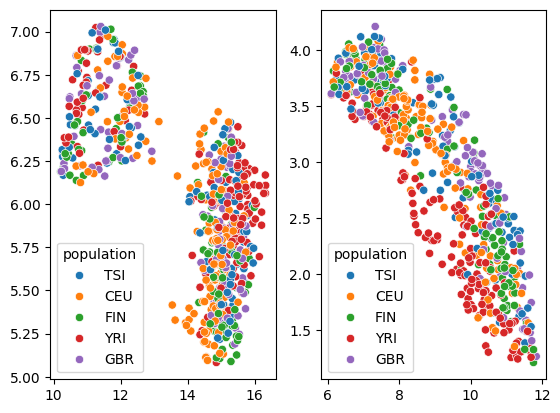

In [88]:
embedding = umap.UMAP(n_components=4)
# embedding = PCA(4)
X_embedded = embedding.fit_transform(StandardScaler().fit_transform(X))

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_header['population'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_header['population'], ax=axs[1])
# plt.show()

In [89]:
fname = next((fdir_external / "BRAIN1" / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / "BRAIN1" / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / "BRAIN1" / 'reg' / 'SraRunTable.txt', sep=',')

In [112]:
# data_eval_header.head().T
data_header.head().T

,ERR188021,ERR188022,ERR188023,ERR188024,ERR188025
Assay Type,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq
AvgSpotLen,150,150,152,150,152
Bases,4876174200,3348579900,5548298680,3572181450,5348693800
BioProject,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366
BioSample,SAMEA1573446,SAMEA1573207,SAMEA1573500,SAMEA1573203,SAMEA1573346
Broker_name,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress
Bytes,3559612733,2387687573,3922060114,2494830964,3609467912
Center Name,UNIGE,UNIGE,CRG,UNIGE,CRG
common_name,human,human,human,human,human
Consent,public,public,public,public,public


<Axes: >

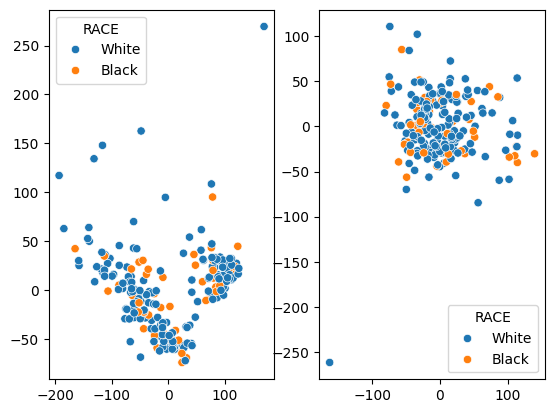

In [91]:
# embedding = umap.UMAP(n_components=4)
embedding = PCA(4)
# X_embedded = embedding.fit_transform(RobustScaler().fit_transform(data_eval.values))
X_embedded = embedding.fit_transform(data_eval.values)

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_eval_header['RACE'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_eval_header['RACE'], ax=axs[1])
# plt.show()